In [44]:
from astropy.table import Table
from astropy.visualization import simple_norm
from photutils.datasets import make_gaussian_sources_image
from photutils import extract_stars, EPSFStar, EPSFStars
from photutils import EPSFModel
from astropy.modeling.models import Gaussian2D
import itertools
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats.funcs import gaussian_sigma_to_fwhm

In [45]:
nStars = 25
nStarsRoot = int(np.sqrt(nStars))

In [46]:
offsets = np.arange(nStarsRoot) * 0.25 - 0.375
xydithers = np.array(list(itertools.product(offsets, offsets)))
xdithers = np.transpose(xydithers)[0]
ydithers = np.transpose(xydithers)[1]
print(xydithers)
print(xydithers.shape)

[[-0.375 -0.375]
 [-0.375 -0.125]
 [-0.375  0.125]
 [-0.375  0.375]
 [-0.375  0.625]
 [-0.125 -0.375]
 [-0.125 -0.125]
 [-0.125  0.125]
 [-0.125  0.375]
 [-0.125  0.625]
 [ 0.125 -0.375]
 [ 0.125 -0.125]
 [ 0.125  0.125]
 [ 0.125  0.375]
 [ 0.125  0.625]
 [ 0.375 -0.375]
 [ 0.375 -0.125]
 [ 0.375  0.125]
 [ 0.375  0.375]
 [ 0.375  0.625]
 [ 0.625 -0.375]
 [ 0.625 -0.125]
 [ 0.625  0.125]
 [ 0.625  0.375]
 [ 0.625  0.625]]
(25, 2)


In [224]:
sources = Table()
y, x = np.mgrid[0:nStarsRoot, 0:nStarsRoot] * 100. + 100.
amp = 100.0
x_std = 3
y_std = 3
sources['amplitude'] = np.full((nStars,), amp)
sources['x_mean'] = x.ravel() + xdithers
sources['y_mean'] = y.ravel() + ydithers
sources['x_stddev'] = np.full((nStars,), x_std)
sources['y_stddev'] = np.full((nStars,), y_std)

print(x_std * gaussian_sigma_to_fwhm)
print(y_std * gaussian_sigma_to_fwhm)
sources

7.0644601350928475
7.0644601350928475


amplitude,x_mean,y_mean,x_stddev,y_stddev
float64,float64,float64,int64,int64
100.0,99.625,99.625,3,3
100.0,199.625,99.875,3,3
100.0,299.625,100.125,3,3
100.0,399.625,100.375,3,3
100.0,499.625,100.625,3,3
100.0,99.875,199.625,3,3
100.0,199.875,199.875,3,3
100.0,299.875,200.125,3,3
100.0,399.875,200.375,3,3


In [225]:
data = make_gaussian_sources_image((int(x.max() + 100), int(x.max() + 100)), sources)

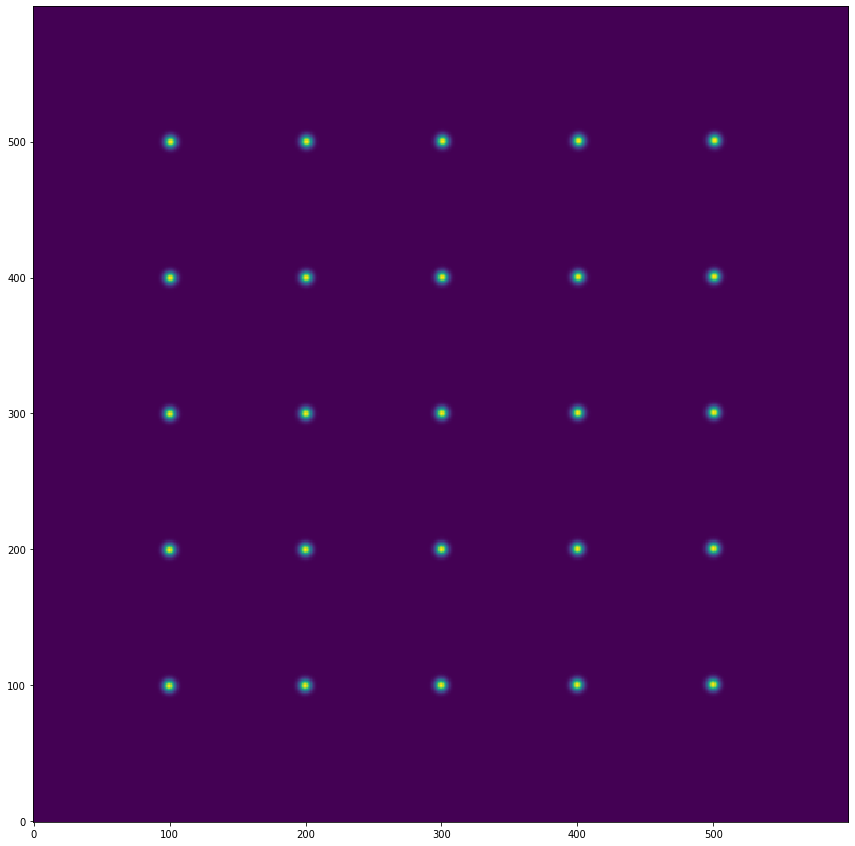

In [226]:
plt.figure(figsize=(15, 15))
norm = simple_norm(data, 'sqrt', percent=99.)
plt.imshow(data, origin='lower')

In [227]:
from astropy.nddata import NDData
nddata = NDData(data=data)

from astropy.table import Table
stars_tbl = Table()
stars_tbl['x'] = sources['x_mean'] 
stars_tbl['y'] = sources['y_mean'] 

from photutils.psf import extract_stars
extr_size = int(4 * 3 * x_std)
if (extr_size % 2) == 0:
    extr_size+=1
#extr_size = 15
stars = extract_stars(nddata, stars_tbl, size=extr_size)
print(extr_size)
print(stars[0].shape)

37
(37, 37)


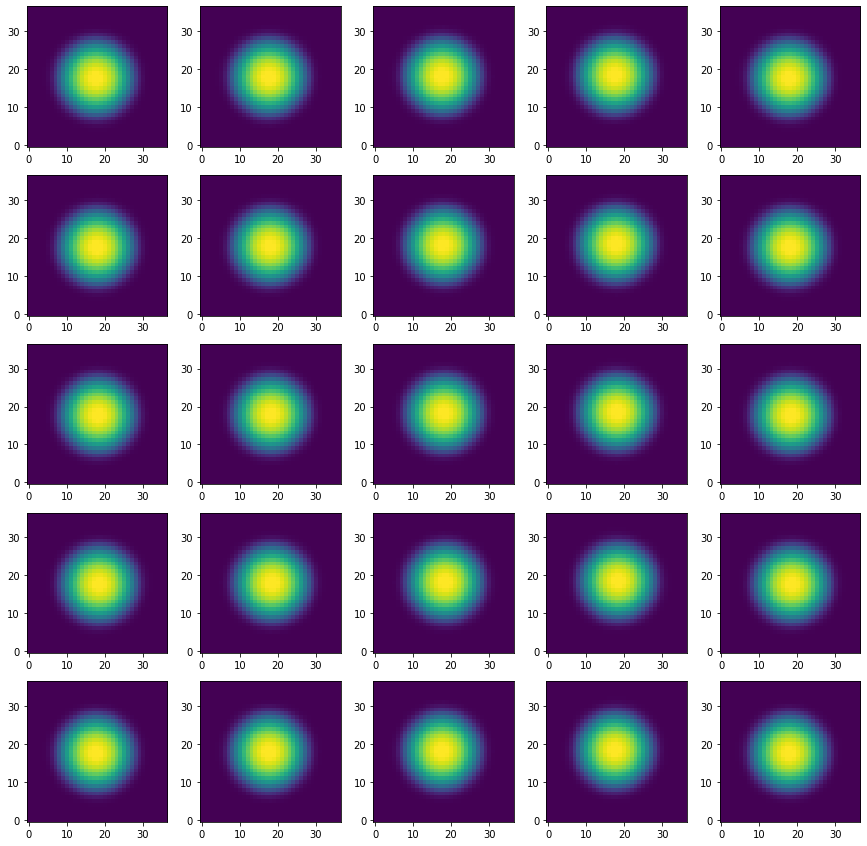

In [228]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
nrows = nStarsRoot
ncols = nStarsRoot
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')

In [234]:
from photutils import EPSFBuilder
oversampling = 1
epsf_builder = EPSFBuilder(oversampling=oversampling, maxiters=10,
                           progress_bar=True)
epsf, fitted_stars = epsf_builder(stars)

(37, 37)


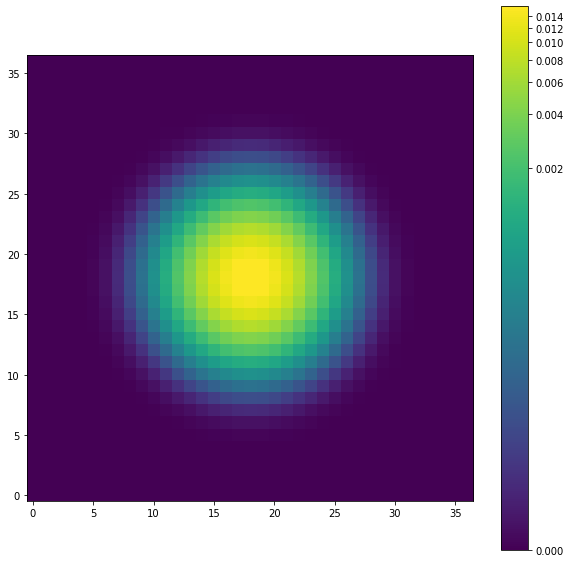

In [235]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
norm = simple_norm(epsf.data, 'log', percent=99.)
plt.figure(figsize=(10,10))
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()
print(epsf.data.shape)

(37, 37)
18.5


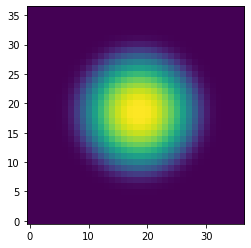

In [236]:
new_size = extr_size * oversampling
m_x = new_size / 2
m_y = new_size / 2
m_stdX = x_std*oversampling
m_stdY = y_std*oversampling
m = Gaussian2D(x_mean=m_x, y_mean=m_y, x_stddev=m_stdX, y_stddev=m_stdY,
               amplitude=1 / (2 * np.pi * m_stdX * m_stdY))

if (new_size % 2 == 0):
    yy, xx = np.mgrid[0 : extr_size * oversampling + 1, 0 : extr_size * oversampling + 1]
else:
    yy, xx = np.mgrid[0 : extr_size * oversampling, 0 : extr_size * oversampling]
data2 = m(xx, yy)

plt.imshow(data2, norm=norm, origin='lower')

print(data2.shape)
print(m_x)

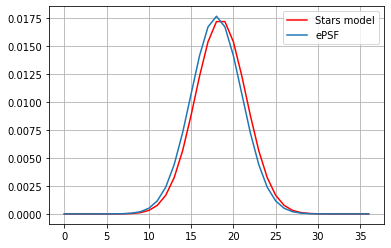

In [237]:
plt.plot(data2[int(m_x), :], color='red', label='Stars model')
#plt.figure()
plt.plot(epsf.data[int(m_x), :], label='ePSF')
plt.legend()
plt.grid()

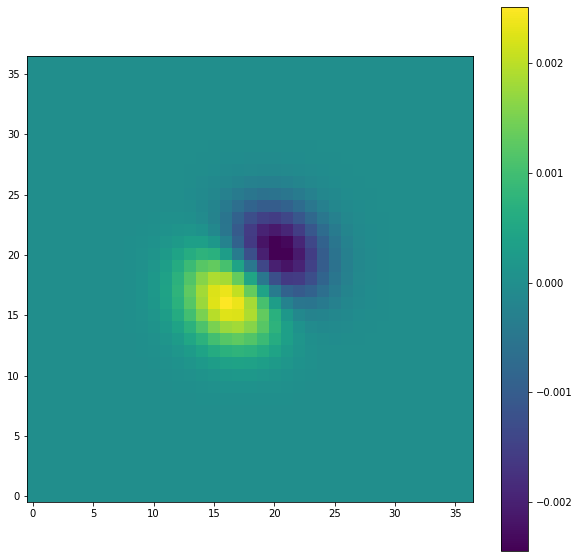

In [238]:
plt.figure(figsize=(10, 10))
plt.imshow(epsf.data - data2, origin='lower')
plt.colorbar()

In [239]:
from tesi.image_fitter import StarsFitter 

In [240]:
threshold = amp - 10
fwhm = gaussian_sigma_to_fwhm * max(x_std, y_std)
ima_fit = StarsFitter(image=data, thresholdInPhot=threshold, fwhm=fwhm, min_separation=3, sharplo=0.2,
                                     sharphi=1., roundlo=-1., roundhi=1., fitshape=(15,15), apertureRadius=13)
ima_fit.fitStars(epsf)
fit_table = ima_fit.getFitTable()
fit_table

x_0,y_0,flux_0,id,group_id,x_fit,y_fit,flux_fit,flux_unc,x_0_unc,y_0_unc
float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64
99.70018671124136,99.70018671124134,5654.347873164283,1,1,99.62536334457215,99.62536334457359,5655.441957152619,0.16366524408410346,0.00012314723111011755,0.00012314723110970862
199.70125951132542,99.90040868656543,5654.348492320925,2,2,199.62536167196487,99.87536323816114,5655.341351810354,0.15586500989100432,0.00011727937603146313,0.00011727255818035456
299.7012595113254,100.09959131343457,5654.348492320926,3,3,299.62535999322427,100.12542294019897,5655.341526086296,0.15600962133189655,0.00011738755941787088,0.00011738025104853476
399.7001867112414,100.29981328875866,5654.347873164283,4,4,399.6253583168713,100.37542067316191,5655.44173799142,0.16372011611496234,0.00012318677803469945,0.00012318903601098765
499.7001867112414,100.70018671124134,5654.347873164283,5,5,499.62535670818437,100.62536332531839,5655.441950622404,0.16366985625509775,0.00012314952154082753,0.00012314843045593048
99.90040868656543,199.70125951132542,5654.348492320926,6,6,99.87536323815985,199.62536167196632,5655.341351810302,0.15586500993714955,0.00011727255821540872,0.00011727937606579356
199.90076009902012,199.90076009902012,5654.3483971795495,7,7,199.87536198353962,199.87536198354093,5655.2407088684595,0.14797339984458815,0.00011133727596619653,0.00011133727596587765
299.90076009902015,200.09923990097988,5654.348397179549,8,8,299.8753607244309,200.12542172697837,5655.240837382874,0.14810931163168334,0.00011143991231782236,0.000111438068468027
399.9004086865654,200.29874048867458,5654.348492320927,9,9,399.87535946585723,200.3754190306146,5655.341085355869,0.15589937937585874,0.0001173000323437888,0.00011730777116604323


In [241]:
x_dev = np.array(fit_table['x_fit'] - sources['x_mean'])
y_dev = np.array(fit_table['y_fit'] - sources['y_mean'])
rms_x = np.sum(x_dev**2) / x_dev.shape[0]
rms_y = np.sum(y_dev**2) / y_dev.shape[0]

print('  x_dev [px], y_dev [px]: \n', np.stack((x_dev, y_dev), axis=-1), 'pixels')
print('rms_x =', rms_x)
print('rms_y =', rms_y)

  x_dev [px], y_dev [px]: 
 [[0.00036334 0.00036334]
 [0.00036167 0.00036324]
 [0.00035999 0.00042294]
 [0.00035832 0.00042067]
 [0.00035671 0.00036333]
 [0.00036324 0.00036167]
 [0.00036198 0.00036198]
 [0.00036072 0.00042173]
 [0.00035947 0.00041903]
 [0.00035827 0.00036166]
 [0.00042294 0.00035999]
 [0.00042173 0.00036072]
 [0.00042047 0.00042047]
 [0.00041918 0.00041735]
 [0.00041799 0.00035998]
 [0.00042067 0.00035832]
 [0.00041903 0.00035947]
 [0.00041735 0.00041918]
 [0.00041564 0.00041564]
 [0.00041402 0.0003583 ]
 [0.00036333 0.00035671]
 [0.00036166 0.00035827]
 [0.00035998 0.00041799]
 [0.0003583  0.00041402]
 [0.00035669 0.00035669]] pixels
rms_x = 1.4806289234188118e-07
rms_y = 1.4806289342879894e-07
